# Master Experiment — Baseline (train.py + run.py)


In [4]:
# 1) Imports + Configuration (baseline train.py/run.py)
import os
from collections import Counter

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.model_selection import train_test_split

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# --- UPDATED PATHS ---
# Direct absolute paths as requested
TRAIN_DIR = '/kaggle/input/deeplearning/train'
TEST_DIR  = '/kaggle/input/deeplearning/test'

# Output directory: using current directory (writable in Kaggle)
MODEL_DIR = './model'
os.makedirs(MODEL_DIR, exist_ok=True)

# Match baseline `model/train.py`
CONFIG = {
    'PATCH_SIZE': 112,
    'STRIDE': 65,           # 75% overlap
    'MIN_INK': 0.02,        # 2% ink threshold
    'BATCH_SIZE': 64,
    'EPOCHS': 55,
    'VAL_SPLIT': 0.15,
}

MODEL_PATH = os.path.join(MODEL_DIR, 'model_pro.keras')
CLASSES_PATH = os.path.join(MODEL_DIR, 'classes_pro.npy')

print('TRAIN_DIR:', TRAIN_DIR)
print('TEST_DIR :', TEST_DIR)
print('MODEL_DIR:', MODEL_DIR)
print('CONFIG   :', CONFIG)

TRAIN_DIR: /kaggle/input/deeplearning/train
TEST_DIR : /kaggle/input/deeplearning/test
MODEL_DIR: ./model
CONFIG   : {'PATCH_SIZE': 112, 'STRIDE': 65, 'MIN_INK': 0.02, 'BATCH_SIZE': 64, 'EPOCHS': 55, 'VAL_SPLIT': 0.15}


In [5]:
# 2) Data Integrity & Verification (baseline train.py)
import os
from collections import Counter

def verify_data_integrity(train_dir: str, test_dir: str):
    """Verifies dataset assumptions (baseline):
    1) 70 writers in train and test
    2) same writer IDs in train and test
    3) exactly 2 test images per writer
    """
    # ANSI colors for nice output in Notebooks
    class Style:
        GREEN = '\033[92m'
        RED = '\033[91m'
        BOLD = '\033[1m'
        RESET = '\033[0m'

    print(f"\n{Style.BOLD}{'='*40}")
    print(f" 2) Data Integrity & Verification")
    print(f"{'='*40}{Style.RESET}")

    def get_id(f: str) -> int:
        return int(f.split('_')[0])

    # Load files
    try:
        train_files = sorted([f for f in os.listdir(train_dir) if f.endswith(('.png', '.jpg'))])
        test_files  = sorted([f for f in os.listdir(test_dir) if f.endswith(('.png', '.jpg'))])
    except FileNotFoundError as e:
        print(f"{Style.RED}❌ Error: Directory not found.{Style.RESET}")
        raise e

    train_ids = [get_id(f) for f in train_files]
    test_ids  = [get_id(f) for f in test_files]

    unique_train = set(train_ids)
    unique_test = set(test_ids)

    # Print Statistics in a Table
    print(f"{'Dataset':<10} | {'Images':<8} | {'Writers':<8}")
    print(f"{'-'*10}-|-{'-'*8}-|-{'-'*8}")
    print(f"{'Train':<10} | {len(train_files):<8} | {len(unique_train):<8}")
    print(f"{'Test':<10} | {len(test_files):<8} | {len(unique_test):<8}")
    print(f"{'-'*30}\n")

    errors = []

    # Check 1: Writer counts
    if len(unique_train) != 70:
        errors.append(f"Expected 70 Train Writers, found {len(unique_train)}")
    if len(unique_test) != 70:
        errors.append(f"Expected 70 Test Writers, found {len(unique_test)}")

    # Check 2: ID mismatches
    if unique_train != unique_test:
        diff = unique_train.symmetric_difference(unique_test)
        errors.append(f"Mismatch between Train/Test Writers. IDs: {diff}")

    # Check 3: Test set distribution
    test_counts = Counter(test_ids)
    incorrect_counts = {k: v for k, v in test_counts.items() if v != 2}
    if incorrect_counts:
        errors.append(f"Test set should have exactly 2 images per writer. Found issues: {incorrect_counts}")

    # Final Result
    if errors:
        print(f"{Style.RED}{Style.BOLD}❌ Data Integrity Failed:{Style.RESET}")
        for e in errors:
            print(f"   • {e}")
        raise RuntimeError('Fix data before proceeding.')
    else:
        print(f"{Style.GREEN}{Style.BOLD}✅ Data Integrity Passed.{Style.RESET}")
        print(f"   (70 Writers confirmed in both sets, 2 test images each).")

# Run the verification
verify_data_integrity(TRAIN_DIR, TEST_DIR)


 2) Data Integrity & Verification
Dataset    | Images   | Writers 
-----------|----------|---------
Train      | 70       | 70      
Test       | 140      | 70      
------------------------------

✅ Data Integrity Passed.
   (70 Writers confirmed in both sets, 2 test images each).


In [6]:
# 3) Patch Extraction + Train Data Loading (baseline train.py)
import sys

def extract_patches_universal(image: np.ndarray, patch_size: int = 112, stride: int = 56):
    """
    Extracts patches using a sliding window.
    - Padding: Adds white border if image < patch_size
    - Threshold: Only keeps patches with ink ratio > MIN_INK
    """
    patches = []
    h, w = image.shape

    # Pad if smaller than patch
    if h < patch_size or w < patch_size:
        pad_h = max(0, patch_size - h)
        pad_w = max(0, patch_size - w)
        image = cv2.copyMakeBorder(image, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=255)
        h, w = image.shape

    # Grid scan
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            crop = image[y:y + patch_size, x:x + patch_size]
            
            # Ink detection (Pixel < 220 is considered ink in grayscale)
            ink_pixels = np.sum(crop < 220)
            ink_ratio = ink_pixels / (patch_size * patch_size)
            
            if ink_ratio > CONFIG['MIN_INK']:
                # Normalize to [0, 1] float32
                crop = crop.astype('float32') / 255.0
                crop = np.expand_dims(crop, axis=-1)
                patches.append(crop)
    return patches

def load_and_patch(directory: str, name: str = 'Dataset'):
    # ANSI Colors
    class Style:
        BLUE = '\033[94m'
        CYAN = '\033[96m'
        GREEN = '\033[92m'
        BOLD = '\033[1m'
        RESET = '\033[0m'

    print(f"\n{Style.BOLD}{'='*40}")
    print(f" 3) Processing: {Style.BLUE}{name}{Style.RESET}")
    print(f"{'='*40}{Style.RESET}")
    
    all_patches = []
    all_labels = []

    files = sorted([f for f in os.listdir(directory) if f.endswith(('.png', '.jpg'))])
    total_files = len(files)
    
    print(f"   • Directory: {directory}")
    print(f"   • Found: {total_files} images")
    print(f"   • Config: Patch={CONFIG['PATCH_SIZE']}, Stride={CONFIG['STRIDE']}, Min Ink={CONFIG['MIN_INK']}")
    print(f"   {Style.CYAN}➜ Extracting patches...{Style.RESET}")

    for i, f in enumerate(files):
        try:
            wid = int(f.split('_')[0])
            path = os.path.join(directory, f)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            
            if img is None:
                continue
            
            patches = extract_patches_universal(img, CONFIG['PATCH_SIZE'], CONFIG['STRIDE'])
            
            for p in patches:
                all_patches.append(p)
                all_labels.append(wid)
                
        except Exception as e:
            print(f"     ⚠️ Skipping error file: {f} ({e})")
            continue

    # Convert to numpy
    X = np.array(all_patches)
    y = np.array(all_labels)
    
    # Calculate memory usage in MB
    mem_size = (X.nbytes + y.nbytes) / (1024 * 1024)

    print(f"\n   {Style.GREEN}✅ {name} Extraction Complete.{Style.RESET}")
    print(f"   {'-'*30}")
    print(f"   • Total Patches : {len(X):,}")
    print(f"   • Data Shape    : {X.shape}")
    print(f"   • Labels Shape  : {y.shape}")
    print(f"   • Memory Usage  : ~{mem_size:.1f} MB")
    print(f"   {'-'*30}")

    return X, y

# Load ONLY Train Data first (baseline)
X_raw, y_raw = load_and_patch(TRAIN_DIR, 'TRAIN SET (Pages)')


 3) Processing: TRAIN SET (Pages)
   • Directory: /kaggle/input/deeplearning/train
   • Found: 70 images
   • Config: Patch=112, Stride=65, Min Ink=0.02
   ➜ Extracting patches...

   ✅ TRAIN SET (Pages) Extraction Complete.
   ------------------------------
   • Total Patches : 22,132
   • Data Shape    : (22132, 112, 112, 1)
   • Labels Shape  : (22132,)
   • Memory Usage  : ~1059.2 MB
   ------------------------------


## 3 Patch + Ink Statistics (useful diagnostics)



 4) Ink Statistics & Distribution
   • Analyzing 70 train images...
   • Min Ink Threshold: 2.00%

--- Writer Statistics (Head) ---


,Writer_ID,Kept_Patches_(>MIN_INK),Ink_Threshold_MIN_INK,Windows_<MIN_INK,Total_Windows,Kept_Rate
0,1,326,0.02,19,345,0.944928
1,2,333,0.02,12,345,0.965217
2,3,329,0.02,16,345,0.953623
3,4,315,0.02,30,345,0.913043
4,5,332,0.02,13,345,0.962319



--- Global Summary ---
   • Total Writers Analyzed   : 70
   • Total Windows Generated  : 24,150
   • Total Kept Patches       : 22,132
   • Median Patches/Writer    : 319
   • Min Patches/Writer       : 251
   • Stats saved to           : ./model/patch_ink_stats_baseline.csv

--- Ink Density Visualization ---


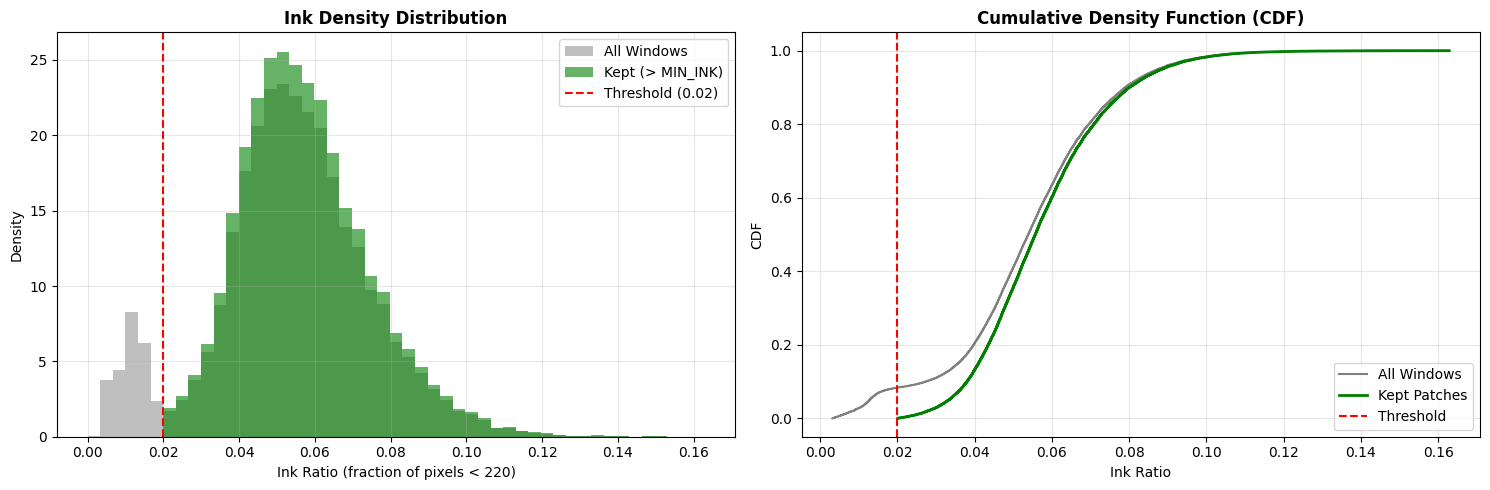


⚠️ Writers with fewest patches (Potential Outliers):


,Writer_ID,Filename,Kept_Patches_(>MIN_INK),Total_Windows,Kept_Rate
9,10,10_1_640.png,251,345,0.727536
44,45,45_1_675.png,252,345,0.730435
65,66,66_1_696.png,274,345,0.794203
61,62,62_1_692.png,280,345,0.811594
58,59,59_1_689.png,281,345,0.814493


In [7]:
# 4) Ink-density curves + per-writer patch/ink table (TRAIN pages)
import matplotlib.pyplot as plt
import seaborn as sns # Optional, but makes plots nicer if available

# ANSI Colors
class Style:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    BOLD = '\033[1m'
    RESET = '\033[0m'

def iter_ink_ratios_for_image(img: np.ndarray, patch_size: int, stride: int):
    """Yields ink_ratio for every sliding window (before filtering)."""
    h, w = img.shape
    if h < patch_size or w < patch_size:
        pad_h = max(0, patch_size - h)
        pad_w = max(0, patch_size - w)
        img = cv2.copyMakeBorder(img, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=255)
        h, w = img.shape

    area = float(patch_size * patch_size)
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            crop = img[y:y + patch_size, x:x + patch_size]
            # < 220 is the threshold for "dark/ink" pixels
            ink_ratio = float(np.sum(crop < 220)) / area
            yield ink_ratio

print(f"\n{Style.BOLD}{'='*40}")
print(f" 4) Ink Statistics & Distribution")
print(f"{'='*40}{Style.RESET}")

# Configuration
train_files = sorted([f for f in os.listdir(TRAIN_DIR) if f.endswith(('.png', '.jpg'))])
min_ink = float(CONFIG['MIN_INK'])
patch_size = int(CONFIG['PATCH_SIZE'])
stride = int(CONFIG['STRIDE'])

print(f"   • Analyzing {len(train_files)} train images...")
print(f"   • Min Ink Threshold: {min_ink:.2%}")

all_ink_ratios = []      # all windows
kept_ink_ratios = []     # windows that pass filter (> min_ink)
rows = []

# --- Main Loop ---
for f in train_files:
    wid = int(f.split('_')[0])
    path = os.path.join(TRAIN_DIR, f)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None: continue

    ratios = list(iter_ink_ratios_for_image(img, patch_size=patch_size, stride=stride))
    if not ratios: continue

    ratios_np = np.asarray(ratios, dtype=np.float32)
    n_total_windows = int(ratios_np.size)

    # Baseline keeps strictly greater than MIN_INK
    kept_mask = ratios_np > min_ink
    n_kept = int(np.sum(kept_mask))

    # Counters
    n_lt_min = int(np.sum(ratios_np < min_ink))
    n_eq_min = int(np.sum(ratios_np == min_ink))

    all_ink_ratios.extend(ratios)
    if n_kept > 0:
        kept_ink_ratios.extend(ratios_np[kept_mask].tolist())

    rows.append({
        'Writer_ID': wid,
        'Filename': f,
        'Patch_Size': patch_size,
        'Stride': stride,
        'Ink_Threshold_MIN_INK': min_ink,
        'Total_Windows': n_total_windows,
        'Kept_Patches_(>MIN_INK)': n_kept,
        'Windows_<MIN_INK': n_lt_min,
        'Windows_==MIN_INK': n_eq_min,
        'Kept_Rate': (n_kept / n_total_windows) if n_total_windows else 0.0,
        'InkRatio_All_Mean': float(np.mean(ratios_np)),
        'InkRatio_All_Median': float(np.median(ratios_np)),
        'InkRatio_Kept_Mean': float(np.mean(ratios_np[kept_mask])) if n_kept else np.nan,
        'InkRatio_Kept_Median': float(np.median(ratios_np[kept_mask])) if n_kept else np.nan,
    })

# Create DataFrame
patch_stats = pd.DataFrame(rows).sort_values(['Writer_ID']).reset_index(drop=True)

# 1. Display Table (Top 5 rows for brevity, or full if needed)
print(f"\n{Style.CYAN}--- Writer Statistics (Head) ---{Style.RESET}")
display(patch_stats[['Writer_ID', 'Kept_Patches_(>MIN_INK)', 'Ink_Threshold_MIN_INK', 'Windows_<MIN_INK', 'Total_Windows', 'Kept_Rate']].head())

# 2. Print Summary Stats
print(f"\n{Style.CYAN}--- Global Summary ---{Style.RESET}")
print(f"   • Total Writers Analyzed   : {patch_stats['Writer_ID'].nunique()}")
print(f"   • Total Windows Generated  : {int(patch_stats['Total_Windows'].sum()):,}")
print(f"   • Total Kept Patches       : {int(patch_stats['Kept_Patches_(>MIN_INK)'].sum()):,}")
print(f"   • Median Patches/Writer    : {int(patch_stats['Kept_Patches_(>MIN_INK)'].median())}")
print(f"   • Min Patches/Writer       : {int(patch_stats['Kept_Patches_(>MIN_INK)'].min())}")

# Save diagnostics table
stats_path = os.path.join(MODEL_DIR, 'patch_ink_stats_baseline.csv')
patch_stats.to_csv(stats_path, index=False)
print(f"   • Stats saved to           : {stats_path}")

# 3. Plotting
print(f"\n{Style.CYAN}--- Ink Density Visualization ---{Style.RESET}")
all_ink = np.asarray(all_ink_ratios, dtype=np.float32)
kept_ink = np.asarray(kept_ink_ratios, dtype=np.float32)

plt.figure(figsize=(15, 5))

# Plot A: Histogram (Density)
plt.subplot(1, 2, 1)
bins = np.linspace(0.0, min(0.25, float(np.max(all_ink)) if all_ink.size else 0.25), 50)
plt.hist(all_ink, bins=bins, density=True, alpha=0.5, color='gray', label='All Windows')
if kept_ink.size:
    plt.hist(kept_ink, bins=bins, density=True, alpha=0.6, color='green', label='Kept (> MIN_INK)')
plt.axvline(min_ink, color='red', linestyle='--', linewidth=1.5, label=f'Threshold ({min_ink})')
plt.title('Ink Density Distribution', fontweight='bold')
plt.xlabel('Ink Ratio (fraction of pixels < 220)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot B: CDF Curve
plt.subplot(1, 2, 2)
xs = np.sort(all_ink)
ys = np.linspace(0.0, 1.0, num=len(xs), endpoint=True)
plt.plot(xs, ys, label='All Windows', color='gray')
if kept_ink.size:
    xs2 = np.sort(kept_ink)
    ys2 = np.linspace(0.0, 1.0, num=len(xs2), endpoint=True)
    plt.plot(xs2, ys2, label='Kept Patches', color='green', linewidth=2)
plt.axvline(min_ink, color='red', linestyle='--', linewidth=1.5, label='Threshold')
plt.title('Cumulative Density Function (CDF)', fontweight='bold')
plt.xlabel('Ink Ratio')
plt.ylabel('CDF')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Low Data Warning
low_data_writers = patch_stats.sort_values('Kept_Patches_(>MIN_INK)').head(5)
print(f"\n{Style.PURPLE}⚠️ Writers with fewest patches (Potential Outliers):{Style.RESET}")
display(low_data_writers[['Writer_ID', 'Filename', 'Kept_Patches_(>MIN_INK)', 'Total_Windows', 'Kept_Rate']])

## 4) Label Mapping + Stratified Split (baseline train.py)
Maps writer IDs to class indices `0..69`, saves `model/classes.npy`, then does a stratified patch-level split into train/val.

In [8]:
# 5) Label Encoding & Data Splitting
# (Assumes X_raw, y_raw, CLASSES_PATH, CONFIG, SEED exist from previous steps)

# ANSI Colors
class Style:
    GREEN = '\033[92m'
    BLUE = '\033[94m'
    BOLD = '\033[1m'
    RESET = '\033[0m'

print(f"\n{Style.BOLD}{'='*40}")
print(f" 5) Label Encoding & Splitting")
print(f"{'='*40}{Style.RESET}")

# 1. Map Labels (Writer IDs -> 0..N-1)
unique_ids = np.unique(y_raw)
NUM_CLASSES = len(unique_ids)

label_map = {original: i for i, original in enumerate(unique_ids)}
inv_label_map = {i: original for original, i in label_map.items()}
y_mapped = np.array([label_map[i] for i in y_raw])

print(f"   • Found {Style.BOLD}{NUM_CLASSES}{Style.RESET} unique writers.")
print(f"   • Label Mapping created (e.g., {unique_ids[0]} -> 0, {unique_ids[-1]} -> {NUM_CLASSES-1})")

# 2. Save Classes
np.save(CLASSES_PATH, unique_ids)
print(f"   • Classes saved to: {Style.BLUE}{CLASSES_PATH}{Style.RESET}")

# 3. Stratified Split
val_pct = CONFIG['VAL_SPLIT']
print(f"\n   {Style.BOLD}➜ Splitting Data{Style.RESET} (Train: {int((1-val_pct)*100)}% | Val: {int(val_pct*100)}%)")

X_train, X_val, y_train, y_val = train_test_split(
    X_raw, y_mapped,
    test_size=val_pct,
    random_state=SEED,
    stratify=y_mapped,
)

# 4. Final Stats
print(f"\n   {Style.GREEN}✅ Split Complete.{Style.RESET}")
print(f"   {'-'*30}")
print(f"   {'Set':<10} | {'Patches':<10} | {'Shape':<15}")
print(f"   {'-'*10}-|-{'-'*10}-|-{'-'*15}")
print(f"   {'Train':<10} | {len(X_train):<10,} | {str(X_train.shape):<15}")
print(f"   {'Val':<10}   | {len(X_val):<10,} | {str(X_val.shape):<15}")
print(f"   {'-'*30}")

del X_raw, y_raw
import gc
gc.collect()
print(f"   (Raw data cleared from memory)")


 5) Label Encoding & Splitting
   • Found 70 unique writers.
   • Label Mapping created (e.g., 1 -> 0, 70 -> 69)
   • Classes saved to: ./model/classes_pro.npy

   ➜ Splitting Data (Train: 85% | Val: 15%)

   ✅ Split Complete.
   ------------------------------
   Set        | Patches    | Shape          
   -----------|------------|----------------
   Train      | 18,812     | (18812, 112, 112, 1)
   Val          | 3,320      | (3320, 112, 112, 1)
   ------------------------------
   (Raw data cleared from memory)


## 5) Model (baseline ResNet-lite)

In [9]:
# 6) Model Architecture: ResNet-Lite
# (Baseline architecture from model/train.py)

# ANSI Colors (Redefined here to ensure it works)
class Style:
    CYAN = '\033[96m'
    BOLD = '\033[1m'
    RESET = '\033[0m'

def build_resnet_lite(input_shape, num_classes: int):
    """
    Builds a lightweight ResNet-style CNN.
    Structure: Stem -> 3 Residual Blocks -> GlobalAvgPool -> Dense Head
    """
    inputs = layers.Input(shape=input_shape)

    # --- Stem ---
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='stem_conv')(inputs)
    x = layers.MaxPooling2D((2, 2), name='stem_pool')(x)

    # --- Block 1 (64 filters) ---
    skip = x
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv1')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv2')(x)
    if skip.shape[-1] != 64:
        skip = layers.Conv2D(64, (1, 1), name='block1_skip_proj')(skip)
    x = layers.Add(name='block1_add')([x, skip])
    x = layers.MaxPooling2D((2, 2), name='block1_pool')(x)
    x = layers.Dropout(0.2, name='block1_dropout')(x)

    # --- Block 2 (128 filters) ---
    skip = x
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv1')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv2')(x)
    if skip.shape[-1] != 128:
        skip = layers.Conv2D(128, (1, 1), name='block2_skip_proj')(skip)
    x = layers.Add(name='block2_add')([x, skip])
    x = layers.MaxPooling2D((2, 2), name='block2_pool')(x)
    x = layers.Dropout(0.3, name='block2_dropout')(x)

    # --- Block 3 (256 filters) ---
    skip = x
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv1')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv2')(x)
    if skip.shape[-1] != 256:
        skip = layers.Conv2D(256, (1, 1), name='block3_skip_proj')(skip)
    x = layers.Add(name='block3_add')([x, skip])
    x = layers.MaxPooling2D((2, 2), name='block3_pool')(x)
    x = layers.Dropout(0.3, name='block3_dropout')(x)

    # --- Head ---
    x = layers.GlobalAveragePooling2D(name='global_pool')(x)
    x = layers.Dense(512, activation='relu', name='dense_fc')(x)
    x = layers.Dropout(0.5, name='dense_dropout')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    return models.Model(inputs, outputs, name='ResNet_Lite')

# --- Build & Compile ---
input_shape = (CONFIG['PATCH_SIZE'], CONFIG['PATCH_SIZE'], 1)

print(f"\n{Style.BOLD}{'='*40}")
print(f" 6) Building Model")
print(f"{'='*40}{Style.RESET}")
print(f"   • Input Shape : {input_shape}")
print(f"   • Classes     : {NUM_CLASSES}")

model = build_resnet_lite(input_shape, NUM_CLASSES)

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

# Print Summary
print(f"\n{Style.CYAN}--- Model Architecture ---{Style.RESET}")
model.summary()


 6) Building Model
   • Input Shape : (112, 112, 1)
   • Classes     : 70


I0000 00:00:1766810735.867334      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



--- Model Architecture ---


Model: "ResNet_Lite"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 112, 112,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_pool           │ (None, 56, 56,    │          0 │ stem_conv[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 56, 56,    │     18,496 │ stem_pool[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 56, 56,    │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_skip_proj    │ (None, 56, 56,    │      2,112 │ stem_pool[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_add (Add)    │ (None, 56, 56,    │          0 │ block1_conv2[0][… │
│                     │ 64)               │            │ block1_skip_proj… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 28, 28,    │          0 │ block1_add[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_dropout      │ (None, 28, 28,    │          0 │ block1_pool[0][0] │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 28, 28,    │     73,856 │ block1_dropout[0… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 28, 28,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_skip_proj    │ (None, 28, 28,    │      8,320 │ block1_dropout[0… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_add (Add)    │ (None, 28, 28,    │          0 │ block2_conv2[0][… │
│                     │ 128)              │            │ block2_skip_proj… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 14, 14,    │          0 │ block2_add[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_dropout      │ (None, 14, 14,    │          0 │ block2_pool[0][0] │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 14, 14,    │    295,168 │ block2_dropout[0… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 14, 14,    │    590,080 │ block3_conv1[0][

 Total params: 1,373,382 (5.24 MB)

 Trainable params: 1,373,382 (5.24 MB)

 Non-trainable params: 0 (0.00 B)

# 7) Training Loop (Baseline)

In [10]:
# --- SAFETY CHECK (Add this to the top) ---
import os
# Ensure the directory exists so saving doesn't fail later
MODEL_DIR = '/kaggle/working/model' 
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    print(f"Created directory: {MODEL_DIR}")
# ------------------------------------------

# ANSI Colors
class Style:
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    CYAN = '\033[96m'
    BOLD = '\033[1m'
    RESET = '\033[0m'

print(f"\n{Style.BOLD}{'='*40}")
print(f" 7) Starting Training")
print(f"{'='*40}{Style.RESET}")

# 1. Configuration & Callbacks
HISTORY_CSV_PATH = os.path.join(MODEL_DIR, 'history_pro.csv')

my_callbacks = [
    # Stop if validation accuracy doesn't improve for 5 epochs
    callbacks.EarlyStopping(
        monitor='val_accuracy', 
        patience=5, 
        restore_best_weights=True, 
        verbose=1
    ),
    # Reduce Learning Rate if validation loss plateaus
    callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=3, 
        verbose=1
    ),
    # Log epoch results to CSV
    callbacks.CSVLogger(HISTORY_CSV_PATH, append=False),
]

print(f"   • Epochs        : {CONFIG['EPOCHS']}")
print(f"   • Batch Size    : {CONFIG['BATCH_SIZE']}")
print(f"   • Log Path      : {HISTORY_CSV_PATH}")
print(f"   {Style.CYAN}➜ Training in progress...{Style.RESET}\n")

# 2. Run Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=CONFIG['EPOCHS'],
    batch_size=CONFIG['BATCH_SIZE'],
    callbacks=my_callbacks,
    verbose=1,
)

# 3. Final Evaluation
print(f"\n{Style.BOLD}➜ Calculating Final Metrics...{Style.RESET}")
train_loss, train_acc_patch = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc_patch = model.evaluate(X_val, y_val, verbose=0)

# 4. Performance Report
print(f"\n{Style.BOLD}{'='*50}")
print(f" FINAL PERFORMANCE REPORT")
print(f"{'='*50}{Style.RESET}")
print(f" {'Metric':<20} | {'Train':<10} | {'Validation':<10}")
print(f" {'-'*20}-|-{'-'*10}-|-{'-'*10}")
print(f" {'Accuracy':<20} | {Style.GREEN}{train_acc_patch*100:6.2f}%{Style.RESET}   | {Style.YELLOW}{val_acc_patch*100:6.2f}%{Style.RESET}")
print(f" {'Loss':<20} | {train_loss:6.4f}      | {val_loss:6.4f}")
print(f"{'='*50}")

# 5. Save Model
model.save(MODEL_PATH)
print(f"\n{Style.GREEN}✅ Model saved successfully to:{Style.RESET}")
print(f"   {MODEL_PATH}")
print(f"   (History saved to {HISTORY_CSV_PATH})")


 7) Starting Training
   • Epochs        : 55
   • Batch Size    : 64
   • Log Path      : /kaggle/working/model/history_pro.csv
   ➜ Training in progress...

Epoch 1/55


I0000 00:00:1766810742.160807     150 service.cc:152] XLA service 0x7ad8b8007140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766810742.160844     150 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1766810742.806265     150 cuda_dnn.cc:529] Loaded cuDNN version 91002


  5/294 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.0172 - loss: 4.2773

I0000 00:00:1766810750.597473     150 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


294/294 ━━━━━━━━━━━━━━━━━━━━ 32s 71ms/step - accuracy: 0.0187 - loss: 4.2088 - val_accuracy: 0.0473 - val_loss: 3.7738 - learning_rate: 5.0000e-04
Epoch 2/55
294/294 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.0489 - loss: 3.7374 - val_accuracy: 0.0819 - val_loss: 3.5313 - learning_rate: 5.0000e-04
Epoch 3/55
294/294 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.0811 - loss: 3.4074 - val_accuracy: 0.1886 - val_loss: 2.8349 - learning_rate: 5.0000e-04
Epoch 4/55
294/294 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.1825 - loss: 2.8367 - val_accuracy: 0.3413 - val_loss: 2.2972 - learning_rate: 5.0000e-04
Epoch 5/55
294/294 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.3301 - loss: 2.2441 - val_accuracy: 0.5247 - val_loss: 1.5615 - learning_rate: 5.0000e-04
Epoch 6/55
294/294 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.4882 - loss: 1.6406 - val_accuracy: 0.5741 - val_loss: 1.3911 - learning_rate: 5.0000e-04
Epoch 7/55
294/294 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accurac

In [11]:
# 8) Final Inference & Result Generation
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

# ANSI Colors
class Style:
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    BOLD = '\033[1m'
    RESET = '\033[0m'

print(f"{Style.BOLD}🚀 Starting Final Inference...{Style.RESET}")

# --- 1. SETUP PATHS (Matching your saved location) ---
WORK_DIR = '/kaggle/working'
MODEL_DIR = os.path.join(WORK_DIR, 'model')
MODEL_PATH = os.path.join(MODEL_DIR, 'model_pro.keras')
CLASSES_PATH = os.path.join(MODEL_DIR, 'classes_pro.npy')
TEST_DIR = '/kaggle/input/deeplearning/test'

CONFIG = {'PATCH_SIZE': 112}

# --- 2. VERIFY FILES EXIST ---
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"❌ Model not found at {MODEL_PATH}. Did training finish?")
if not os.path.exists(CLASSES_PATH):
    raise FileNotFoundError(f"❌ Classes file not found at {CLASSES_PATH}.")

print(f"   • Loading Model from: {MODEL_PATH}")
model_inf = tf.keras.models.load_model(MODEL_PATH)

print(f"   • Loading Classes from: {CLASSES_PATH}")
unique_ids = np.load(CLASSES_PATH)
inv_label_map = {i: uid for i, uid in enumerate(unique_ids)}

# --- 3. RUN PREDICTIONS ---
test_files = sorted([f for f in os.listdir(TEST_DIR) if f.endswith(('.png', '.jpg'))])
print(f"   • Found {len(test_files)} test images.")
print(f"   ➜ Processing...", end='')

results = []
correct_count = 0

for i, f in enumerate(test_files):
    if i % 10 == 0: print('.', end='', flush=True) # Progress dots
    
    # Load Image
    path = os.path.join(TEST_DIR, f)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    true_label = int(f.split('_')[0])
    
    # Extract Patches
    patches = []
    h, w = img.shape
    # Pad if needed
    if h < 112 or w < 112:
        img = cv2.copyMakeBorder(img, 0, max(0,112-h), 0, max(0,112-w), cv2.BORDER_CONSTANT, value=255)
        h, w = img.shape

    # Detailed Scan (Stride 60)
    for y in range(0, h - 112 + 1, 60):
        for x in range(0, w - 112 + 1, 60):
            crop = img[y:y+112, x:x+112]
            # Ink check (skip empty white patches)
            if np.sum(crop < 220) / (112*112) > 0.02:
                patches.append(crop)

    # Predict
    if not patches:
        pred_label = unique_ids[0] # Default
    else:
        # Normalize & Shape
        batch_x = np.array(patches, dtype='float32') / 255.0
        batch_x = np.expand_dims(batch_x, axis=-1)
        
        # Get probabilities
        probs = model_inf.predict(batch_x, verbose=0)
        
        # Soft Voting (Sum probabilities across all patches)
        summed = np.sum(probs, axis=0)
        pred_idx = np.argmax(summed)
        pred_label = inv_label_map[pred_idx]

    status = 'Correct' if pred_label == true_label else 'Incorrect'
    if status == 'Correct': correct_count += 1
    
    results.append({
        'Filename': f,
        'Actual_Label': true_label,
        'Predicted_Label': pred_label
    })

# --- 4. FINAL RESULTS ---
acc = correct_count / len(test_files)
print(f"\n\n{Style.BOLD}{'='*40}")
print(f" FINAL TEST RESULT")
print(f"{'='*40}{Style.RESET}")
print(f" Test Accuracy: {Style.GREEN}{acc*100:.2f}%{Style.RESET}")

# Save CSV
df = pd.DataFrame(results)
output_csv = os.path.join(WORK_DIR, 'result_pro.csv')
df.to_csv(output_csv, index=False)
print(f" CSV saved to: {output_csv}")
print(f"{Style.YELLOW}👉 Download 'result_pro.csv' from the Output tab now!{Style.RESET}")

🚀 Starting Final Inference...
   • Loading Model from: /kaggle/working/model/model_pro.keras
   • Loading Classes from: /kaggle/working/model/classes_pro.npy
   • Found 140 test images.
   ➜ Processing.................

 FINAL TEST RESULT
 Test Accuracy: 90.71%
 CSV saved to: /kaggle/working/result_pro.csv
👉 Download 'result_pro.csv' from the Output tab now!


In [12]:
# 8) Inference & Result Generation (Fixed Paths & Colors)
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display

# ANSI Colors (Fixed to include BLUE)
class Style:
    GREEN = '\033[92m'
    RED = '\033[91m'
    YELLOW = '\033[93m'
    CYAN = '\033[96m'
    BLUE = '\033[94m'
    BOLD = '\033[1m'
    RESET = '\033[0m'

print(f"\n{Style.BOLD}{'='*40}")
print(f" 8) Inference on Test Set (Absolute Paths)")
print(f"{'='*40}{Style.RESET}")

# --- FIX: Force Absolute Paths ---
WORK_DIR = '/kaggle/working'
MODEL_DIR = os.path.join(WORK_DIR, 'model')
MODEL_PATH = os.path.join(MODEL_DIR, 'model_pro.keras')
CLASSES_PATH = os.path.join(MODEL_DIR, 'classes_pro.npy')
TEST_DIR = '/kaggle/input/deeplearning/test'

CONFIG = {'PATCH_SIZE': 112, 'STRIDE': 65}

# --- DEBUG STEP: Find the file ---
print(f"   • Current Working Directory: {os.getcwd()}")
print(f"   • Looking for model in: {MODEL_PATH}")

if not os.path.exists(MODEL_PATH):
    print(f"\n{Style.RED}❌ File not found at specific path. Searching directory...{Style.RESET}")
    found = False
    for root, dirs, files in os.walk(WORK_DIR):
        for file in files:
            if file == 'model_pro.keras':
                print(f"   ✅ FOUND IT AT: {os.path.join(root, file)}")
                MODEL_PATH = os.path.join(root, file)
                found = True
    if not found:
        raise FileNotFoundError(f"{Style.RED}CRITICAL: Model file was not saved. Check Training Step.{Style.RESET}")

# 1. Verification
if not os.path.exists(CLASSES_PATH):
    if os.path.exists(os.path.join(WORK_DIR, 'model', 'classes_pro.npy')):
        CLASSES_PATH = os.path.join(WORK_DIR, 'model', 'classes_pro.npy')
    else:
        # Fallback if classes file is missing but model exists (rare)
        raise FileNotFoundError(f"{Style.RED}Classes file missing. Cannot map IDs.{Style.RESET}")

# 2. Load Resources
print(f"   • Loading Model: {Style.CYAN}{MODEL_PATH}{Style.RESET}")
model_inf = tf.keras.models.load_model(MODEL_PATH)

print(f"   • Loading Classes: {Style.CYAN}{CLASSES_PATH}{Style.RESET}")
unique_ids = np.load(CLASSES_PATH)
inv_label_map = {i: original for i, original in enumerate(unique_ids)}

# 3. Inference Loop
try:
    test_files = sorted([f for f in os.listdir(TEST_DIR) if f.endswith(('.png', '.jpg'))])
except FileNotFoundError:
    print(f"{Style.RED}❌ Test directory not found: {TEST_DIR}{Style.RESET}")
    test_files = []

total_files = len(test_files)
print(f"   • Found {total_files} test images.")
print(f"\n   {Style.YELLOW}➜ Running Ensemble Voting...{Style.RESET}")

correct_test_images = 0
results = []

def extract_patches_local(image, patch_size, stride):
    patches_local = []
    h, w = image.shape
    if h < patch_size or w < patch_size:
        pad_h = max(0, patch_size - h)
        pad_w = max(0, patch_size - w)
        image = cv2.copyMakeBorder(image, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=255)
        h, w = image.shape
        
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            crop = image[y:y + patch_size, x:x + patch_size]
            if np.sum(crop < 220) / (patch_size**2) > 0.02: 
                crop = crop.astype('float32') / 255.0
                patches_local.append(np.expand_dims(crop, axis=-1))
    return patches_local

for i, f in enumerate(test_files):
    if (i + 1) % 10 == 0:
        print(f"     Processing image {i + 1}/{total_files}...", end='\r')

    path = os.path.join(TEST_DIR, f)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    
    true_label = int(f.split('_')[0])

    patches = extract_patches_local(img, CONFIG['PATCH_SIZE'], CONFIG['STRIDE'])
    
    if not patches:
        pred_label = unique_ids[0] # Fallback
        confidence = 0.0
    else:
        patches = np.array(patches)
        probs = model_inf.predict(patches, verbose=0)
        
        # Soft voting
        summed_probs = np.sum(probs, axis=0) 
        pred_idx = int(np.argmax(summed_probs))
        pred_label = int(inv_label_map[pred_idx])
        confidence = float(summed_probs[pred_idx] / len(patches))

    status = 'Correct' if pred_label == true_label else 'Incorrect'
    if pred_label == true_label:
        correct_test_images += 1

    results.append({
        'Filename': f,
        'Actual_Label': true_label,
        'Predicted_Label': pred_label,
        'Confidence': confidence,
        'Status': status,
    })

print(f"     Processing image {total_files}/{total_files} - Done.      ")

# 4. Final Metrics
if total_files > 0:
    test_acc_image = correct_test_images / total_files
else:
    test_acc_image = 0

print(f"\n{Style.BOLD}{'='*50}")
print(f" FINAL TEST REPORT")
print(f"{'='*50}{Style.RESET}")

if test_acc_image > 0.9: color = Style.GREEN
elif test_acc_image > 0.7: color = Style.YELLOW
else: color = Style.RED

print(f" Test Accuracy (Image-level): {color}{test_acc_image*100:.2f}%{Style.RESET}")
print(f" Correct Predictions: {correct_test_images}/{total_files}")
print(f"{'='*50}")

# 5. Save Results
if results:
    df_results = pd.DataFrame(results)
    
    # Save to /kaggle/working/ explicitly
    output_csv = os.path.join(WORK_DIR, 'result_pro.csv')
    df_results[['Filename', 'Actual_Label', 'Predicted_Label']].to_csv(output_csv, index=False)
    print(f"\n   • CSV Results saved to: {Style.BLUE}{output_csv}{Style.RESET}")

    # Markdown Report
    df_results['Status_Order'] = df_results['Status'].apply(lambda x: 0 if x == 'Correct' else 1)
    df_sorted = df_results.sort_values(by=['Status_Order', 'Confidence'], ascending=[True, False])

    md_content = "# Test Results Report\n\n"
    md_content += f"**Overall Accuracy:** {test_acc_image*100:.2f}%\n\n"
    md_content += "| Filename | Actual Label | Predicted Label | Confidence | Status |\n"
    md_content += "|---|---|---|---|---|\n"
    for _, row in df_sorted.iterrows():
        icon = "✅" if row['Status'] == 'Correct' else "❌"
        md_content += f"| {row['Filename']} | {row['Actual_Label']} | {row['Predicted_Label']} | {row['Confidence']:.4f} | {icon} {row['Status']} |\n"

    output_md = os.path.join(WORK_DIR, 'result_pro.md')
    with open(output_md, 'w') as f:
        f.write(md_content)
    print(f"   • Detailed Report saved to: {Style.BLUE}{output_md}{Style.RESET}")
    
    # Show errors
    errors = df_results[df_results['Status'] == 'Incorrect']
    if not errors.empty:
        print(f"\n{Style.RED}⚠️  Incorrect Predictions:{Style.RESET}")
        display(errors[['Filename', 'Actual_Label', 'Predicted_Label', 'Confidence']])
    else:
        print(f"\n{Style.GREEN}🎉 Perfect Score! No errors found.{Style.RESET}")


 8) Inference on Test Set (Absolute Paths)
   • Current Working Directory: /kaggle/working
   • Looking for model in: /kaggle/working/model/model_pro.keras
   • Loading Model: /kaggle/working/model/model_pro.keras
   • Loading Classes: /kaggle/working/model/classes_pro.npy
   • Found 140 test images.

   ➜ Running Ensemble Voting...
     Processing image 140/140 - Done.      

 FINAL TEST REPORT
 Test Accuracy (Image-level): 90.00%
 Correct Predictions: 126/140

   • CSV Results saved to: /kaggle/working/result_pro.csv
   • Detailed Report saved to: /kaggle/working/result_pro.md

⚠️  Incorrect Predictions:


,Filename,Actual_Label,Predicted_Label,Confidence
2,02_2_352.png,2,26,0.428058
20,11_2_361.png,11,9,0.228311
24,13_2_293.png,13,23,0.446720
34,18_2_368.png,18,49,0.187100
35,18_2_508.png,18,49,0.210544
60,31_2_311.png,31,44,0.235433
64,33_2_383.png,33,29,0.341484
65,33_2_523.png,33,29,0.286788
67,34_2_524.png,34,64,0.233081
78,40_2_390.png,40,1,0.291905


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

try:
    import seaborn as sns
    sns.set_theme(style='darkgrid')
except Exception as e:
    sns = None
    print("Seaborn not available; using matplotlib only.")
    print(f"Import error: {type(e).__name__}: {e}")

def _safe_multiclass_auc(y_true_idx: np.ndarray, y_prob: np.ndarray) -> float:
    """Returns macro OVR ROC-AUC for multiclass, or NaN if not computable."""
    try:
        return float(
            roc_auc_score(
                y_true_idx,
                y_prob,
                multi_class='ovr',
                average='macro',
            )
        )
    except Exception as e:
        print(f"AUC not computed ({type(e).__name__}): {e}")
        return float('nan')

# --- Train / Val (patch-level) ---
print("Computing Train/Val metrics (patch-level)...")
batch_size = int(CONFIG.get('BATCH_SIZE', 64))

train_prob = model.predict(X_train, batch_size=batch_size, verbose=0)
val_prob = model.predict(X_val, batch_size=batch_size, verbose=0)

train_pred = np.argmax(train_prob, axis=1)
val_pred = np.argmax(val_prob, axis=1)

train_acc = float(accuracy_score(y_train, train_pred))
val_acc = float(accuracy_score(y_val, val_pred))

train_f1 = float(f1_score(y_train, train_pred, average='macro'))
val_f1 = float(f1_score(y_val, val_pred, average='macro'))

train_auc = _safe_multiclass_auc(y_train, train_prob)
val_auc = _safe_multiclass_auc(y_val, val_prob)

# --- Test (image-level, soft voting like Cell 14, but keep per-class probabilities for AUC) ---
print("Computing Test metrics (image-level, soft voting)...")
if 'model_inf' not in globals():
    model_inf = tf.keras.models.load_model(MODEL_PATH)
if 'unique_ids' not in globals():
    unique_ids = np.load(CLASSES_PATH)

# map writer-id -> class-index
label_map_ids = {int(wid): int(i) for i, wid in enumerate(unique_ids)}

y_test_idx = []
y_test_prob = []  # shape: (n_images, n_classes)

test_files_local = sorted([f for f in os.listdir(TEST_DIR) if f.endswith(('.png', '.jpg'))])
for f in test_files_local:
    true_wid = int(f.split('_')[0])
    true_idx = label_map_ids.get(true_wid, None)
    if true_idx is None:
        continue
    img_path = os.path.join(TEST_DIR, f)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    patches = extract_patches_universal(img, CONFIG['PATCH_SIZE'], CONFIG['STRIDE'])
    if len(patches) == 0:
        continue
    patches = np.asarray(patches)
    probs = model_inf.predict(patches, batch_size=batch_size, verbose=0)
    summed = np.sum(probs, axis=0)
    # normalize to a probability distribution (good for AUC)
    denom = float(np.sum(summed))
    prob_vec = (summed / denom) if denom > 0 else summed
    y_test_idx.append(true_idx)
    y_test_prob.append(prob_vec)

y_test_idx = np.asarray(y_test_idx, dtype=np.int64)
y_test_prob = np.asarray(y_test_prob, dtype=np.float32)

test_pred = np.argmax(y_test_prob, axis=1)
test_acc = float(accuracy_score(y_test_idx, test_pred))
test_f1 = float(f1_score(y_test_idx, test_pred, average='macro'))
test_auc = _safe_multiclass_auc(y_test_idx, y_test_prob)

metrics_df = pd.DataFrame(
    {
        'Set': ['Train', 'Val', 'Test'],
        'Accuracy': [train_acc, val_acc, test_acc],
        'F1 (macro)': [train_f1, val_f1, test_f1],
        'AUC (macro OVR)': [train_auc, val_auc, test_auc],
    }
).set_index('Set')

display(metrics_df.style.format('{:.4f}'))

# --- Enhanced bar plot (Seaborn darkgrid + value labels) ---
plot_df = (
    metrics_df.reset_index()
    .melt(id_vars='Set', var_name='Metric', value_name='Score')
    .copy()
 )

fig, ax = plt.subplots(figsize=(10, 4))

if sns is not None:
    sns.barplot(data=plot_df, x='Set', y='Score', hue='Metric', ax=ax)
else:
    # fallback to matplotlib (still labeled)
    metric_order = plot_df['Metric'].unique().tolist()
    sets = plot_df['Set'].unique().tolist()
    x = np.arange(len(sets))
    width = 0.8 / max(1, len(metric_order))
    for i, metric_name in enumerate(metric_order):
        vals = metrics_df[metric_name].values
        ax.bar(x + (i - (len(metric_order)-1)/2) * width, vals, width, label=metric_name)
    ax.set_xticks(x)
    ax.set_xticklabels(sets)
    ax.legend(title='Metric')

ax.set_ylim(0.0, 1.0)
ax.set_ylabel('Score')
ax.set_title('Train / Val / Test Metrics')

# Value labels above bars
for p in ax.patches:
    height = p.get_height()
    if np.isnan(height):
        continue
    ax.annotate(
        f"{height:.3f}",
        (p.get_x() + p.get_width() / 2.0, height),
        ha='center',
        va='bottom',
        fontsize=9,
        xytext=(0, 3),
        textcoords='offset points',
    )

plt.tight_layout()
plt.show()

Computing Train/Val metrics (patch-level)...
Computing Test metrics (image-level, soft voting)...


KeyError: 'MIN_INK'

📊 Generating Training Curves...
   • Loaded history from: /kaggle/working/model/history_pro.csv


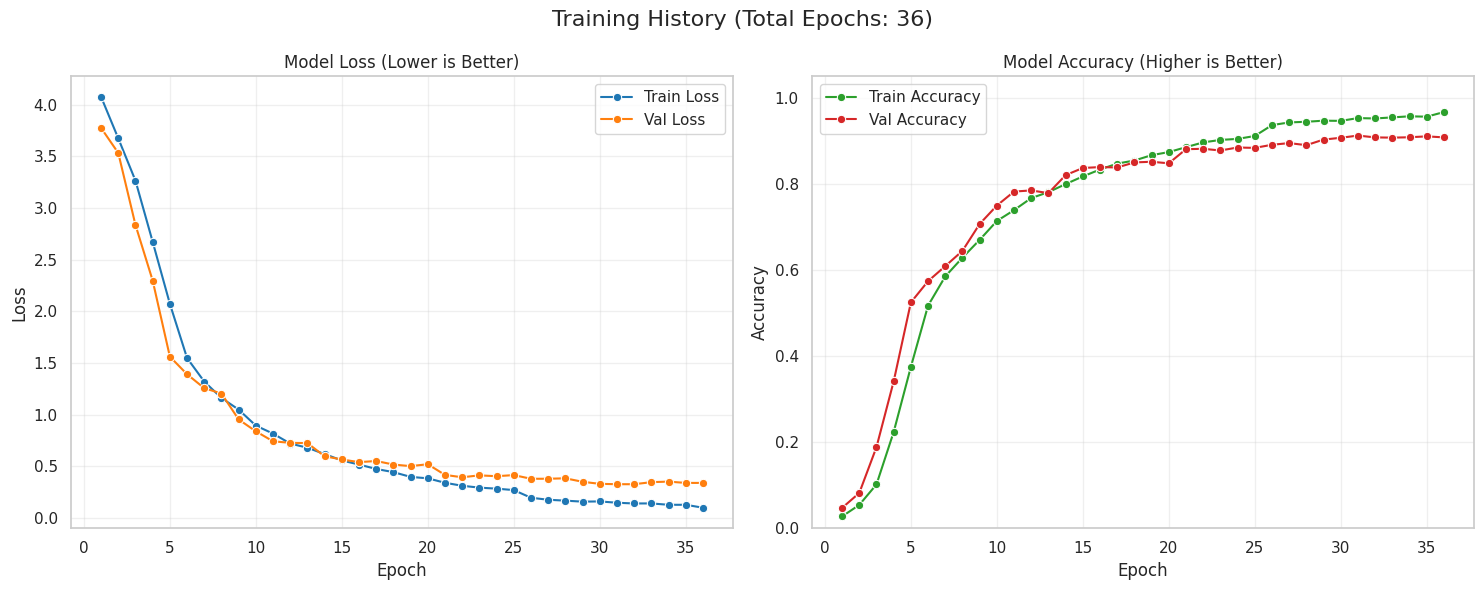

In [14]:
# 9) Training Curves (Loss + Accuracy) - Robust Version
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try importing Seaborn for nicer plots
try:
    import seaborn as sns
    sns.set_theme(style='whitegrid')
except Exception:
    sns = None
    print("Seaborn not found, using standard matplotlib.")

print("📊 Generating Training Curves...")

# --- 1. ROBUST PATH FINDING ---
# We prioritize the known Kaggle output directory
POSSIBLE_PATHS = [
    '/kaggle/working/model/history_pro.csv',        # Best bet
    os.path.join(os.getcwd(), 'model', 'history_pro.csv'),
    'history_pro.csv'
]

history_csv_path = None
for p in POSSIBLE_PATHS:
    if os.path.exists(p):
        history_csv_path = p
        break

if history_csv_path is None:
    # Don't crash, just inform the user
    print("❌ Could not find 'history_pro.csv'.")
    print("   Did you run the Training Step (Step 7)?")
    print("   Skipping plot generation.")
else:
    print(f"   • Loaded history from: {history_csv_path}")
    df_hist = pd.read_csv(history_csv_path)

    # --- 2. DATA PREP ---
    # Handle Epochs (create 1-based index if missing)
    if 'epoch' not in df_hist.columns:
        df_hist['epoch'] = np.arange(1, len(df_hist) + 1)
    else:
        # If 0-based, make it 1-based for the chart
        if df_hist['epoch'].min() == 0:
            df_hist['epoch'] += 1

    # identify columns dynamically
    loss_col = next((c for c in ['loss', 'train_loss'] if c in df_hist.columns), None)
    val_loss_col = next((c for c in ['val_loss', 'validation_loss'] if c in df_hist.columns), None)
    acc_col = next((c for c in ['accuracy', 'acc', 'train_accuracy'] if c in df_hist.columns), None)
    val_acc_col = next((c for c in ['val_accuracy', 'val_acc'] if c in df_hist.columns), None)

    # --- 3. PLOTTING ---
    if loss_col:
        fig, axes = plt.subplots(1, 2 if acc_col else 1, figsize=(15, 6))
        if not isinstance(axes, np.ndarray): axes = [axes]

        # Plot Loss
        ax = axes[0]
        if sns:
            sns.lineplot(data=df_hist, x='epoch', y=loss_col, label='Train Loss', marker='o', ax=ax, color='tab:blue')
            if val_loss_col:
                sns.lineplot(data=df_hist, x='epoch', y=val_loss_col, label='Val Loss', marker='o', ax=ax, color='tab:orange')
        else:
            ax.plot(df_hist['epoch'], df_hist[loss_col], label='Train Loss', marker='o')
            if val_loss_col:
                ax.plot(df_hist['epoch'], df_hist[val_loss_col], label='Val Loss', marker='o')
        
        ax.set_title('Model Loss (Lower is Better)')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.grid(True, alpha=0.3)
        ax.legend()

        # Plot Accuracy (if available)
        if acc_col and len(axes) > 1:
            ax = axes[1]
            if sns:
                sns.lineplot(data=df_hist, x='epoch', y=acc_col, label='Train Accuracy', marker='o', ax=ax, color='tab:green')
                if val_acc_col:
                    sns.lineplot(data=df_hist, x='epoch', y=val_acc_col, label='Val Accuracy', marker='o', ax=ax, color='tab:red')
            else:
                ax.plot(df_hist['epoch'], df_hist[acc_col], label='Train Accuracy', marker='o')
                if val_acc_col:
                    ax.plot(df_hist['epoch'], df_hist[val_acc_col], label='Val Accuracy', marker='o')
            
            ax.set_title('Model Accuracy (Higher is Better)')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Accuracy')
            ax.set_ylim(0, 1.05)
            ax.grid(True, alpha=0.3)
            ax.legend()

        plt.suptitle(f'Training History (Total Epochs: {len(df_hist)})', fontsize=16)
        plt.tight_layout()
        plt.show()
    else:
        print("❌ Loss column not found in CSV. Cannot plot.")

📊 Visualizing 70 images...


/tmp/ipykernel_55/783132996.py:70: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_55/783132996.py:70: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


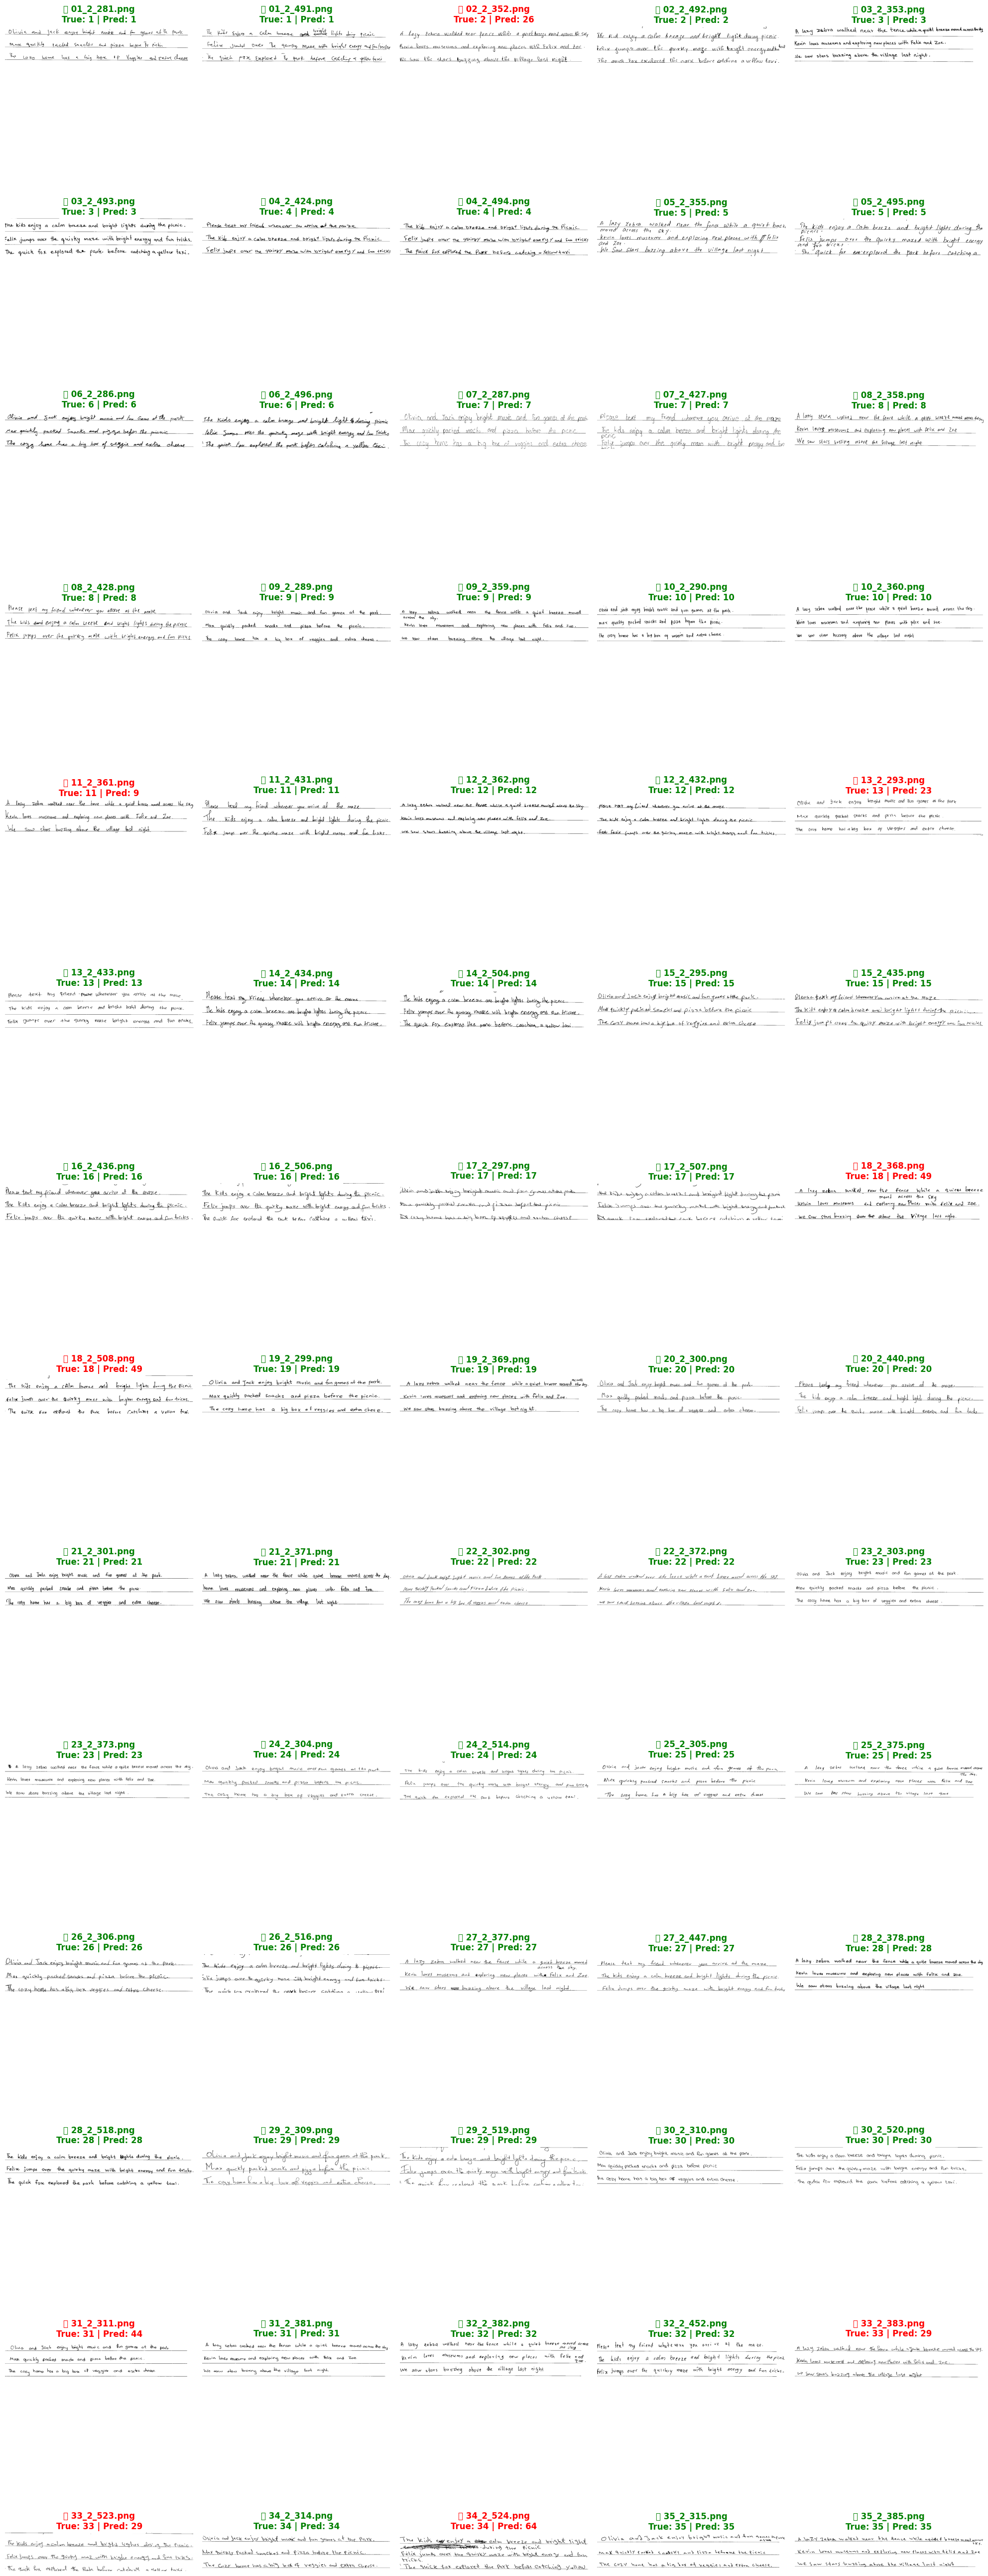

In [15]:
# 10) Visualize Predictions (Green vs Red)
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import math

# --- CONFIG ---
NUM_TO_SHOW = 70  # Change this to 140 to see ALL images
COLS = 5          # Images per row
CSV_PATH = '/kaggle/working/result_pro.csv'

# Ensure we use the correct test directory
# (Try the variable from memory first, else fallback to hardcoded path)
if 'TEST_DIR' not in globals():
    TEST_DIR = '/kaggle/input/deep-learning/test'

# --- LOAD DATA ---
if not os.path.exists(CSV_PATH):
    print("❌ result_pro.csv not found. Please run the Inference step first.")
else:
    df = pd.read_csv(CSV_PATH)
    
    # Optional: Sort so Errors appear first? 
    # Uncomment next line to see Red images first
    # df = df.sort_values(by='Status', ascending=True) 

    # Take a subset
    subset = df.head(NUM_TO_SHOW)
    
    # Calculate grid size
    rows = math.ceil(len(subset) / COLS)
    
    print(f"📊 Visualizing {len(subset)} images...")
    
    # Create Figure
    plt.figure(figsize=(20, 4 * rows))
    
    for i, (index, row) in enumerate(subset.iterrows()):
        ax = plt.subplot(rows, COLS, i + 1)
        
        # Load Image
        img_path = os.path.join(TEST_DIR, row['Filename'])
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
        else:
            # Placeholder if image missing
            plt.text(0.5, 0.5, "Image Not Found", ha='center')
        
        # Determine Color & Status
        is_correct = (row['Actual_Label'] == row['Predicted_Label'])
        color = 'green' if is_correct else 'red'
        icon = '✅' if is_correct else '❌'
        
        # Styling
        plt.axis('off')
        
        # Add colored border
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color(color)
            spine.set_linewidth(4) # Thick border
            
        # Add colored title
        title = f"{icon} {row['Filename']}\nTrue: {row['Actual_Label']} | Pred: {row['Predicted_Label']}"
        plt.title(title, color=color, fontsize=12, fontweight='bold', backgroundcolor='white')

    plt.tight_layout()
    plt.show()

✅ Loading model from: /kaggle/working/model/model_pro.keras
🚀 Computing Advanced Metrics for 70 classes...
   Processing 140/140...
✅ Processing Complete. Calculating metrics...


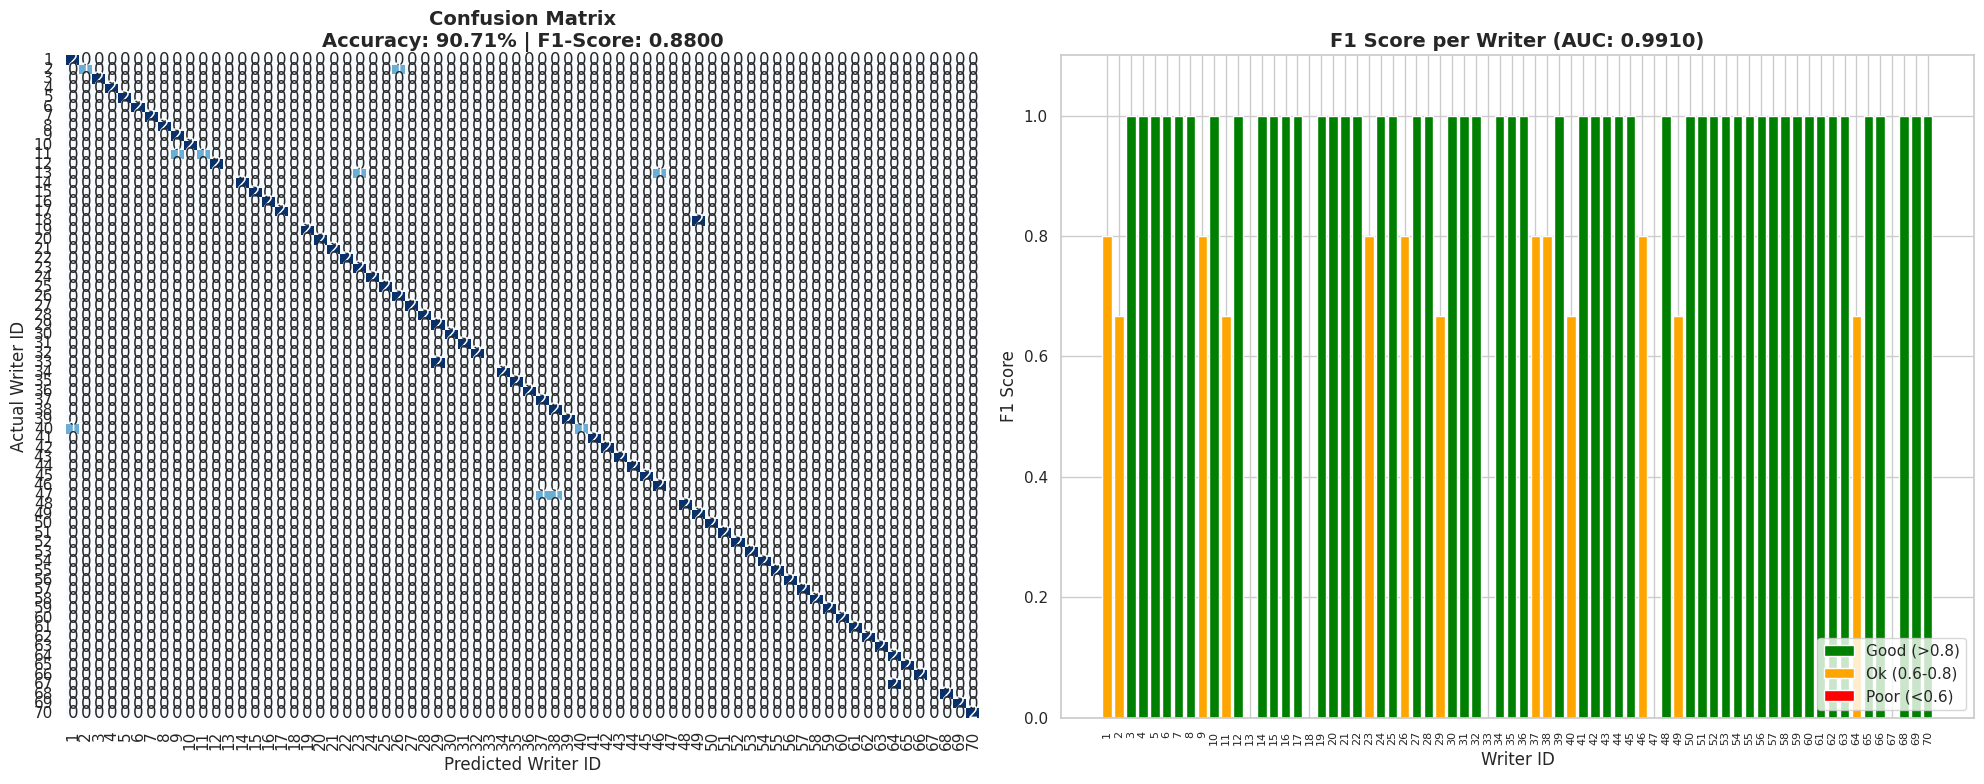

------------------------------
FINAL MODEL REPORT
------------------------------
Global Accuracy : 90.71%
Macro F1 Score  : 0.8800
ROC AUC Score   : 0.9910
------------------------------


In [16]:
# 11) Advanced Metrics & Visualizations (Fixed Paths)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, accuracy_score
import os
import cv2
import tensorflow as tf

# --- CONFIG & PATH FIX ---
# Define possible locations for the model
possible_paths = [
    '/kaggle/working/model/model_pro.keras',  # Standard save path
    '/kaggle/working/model_pro.keras',        # Backup
    'model/model_pro.keras',
    'model_pro.keras'
]

model_path = next((p for p in possible_paths if os.path.exists(p)), None)
classes_path = model_path.replace('model_pro.keras', 'classes_pro.npy') if model_path else None

if not model_path or not os.path.exists(model_path):
    raise FileNotFoundError("❌ Could not find model_pro.keras. Make sure you ran the Training step.")

print(f"✅ Loading model from: {model_path}")

# Load Resources
model = tf.keras.models.load_model(model_path)
unique_ids = np.load(classes_path)

if 'TEST_DIR' not in globals():
    TEST_DIR = '/kaggle/input/deep-learning/test' # Check your specific input path

print(f"🚀 Computing Advanced Metrics for {len(unique_ids)} classes...")

# --- 1. GENERATE PREDICTIONS (Image Level) ---
y_true = []
y_pred = []
y_probs = [] # Needed for AUC

# Re-define patch extractor to be safe
def get_patches_eval(img):
    patches = []
    h, w = img.shape
    if h < 112 or w < 112: return []
    for y in range(0, h-112, 60):
        for x in range(0, w-112, 60):
            crop = img[y:y+112, x:x+112]
            if np.sum(crop < 220)/(112**2) > 0.02:
                patches.append(crop)
    return np.array(patches)

test_files = sorted([f for f in os.listdir(TEST_DIR) if f.endswith(('.png', '.jpg'))])
label_map = {uid: i for i, uid in enumerate(unique_ids)}

# Limit to first 200 images if dataset is huge, to save time
# test_files = test_files[:200] 

for i, f in enumerate(test_files):
    if (i+1) % 20 == 0: print(f"   Processing {i+1}/{len(test_files)}...", end='\r')
    
    try:
        real_id = int(f.split('_')[0])
        if real_id not in label_map: continue 
        
        img_path = os.path.join(TEST_DIR, f)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None: continue
        
        patches = get_patches_eval(img)
        
        if len(patches) > 0:
            patches = patches.astype('float32') / 255.0
            patches = np.expand_dims(patches, -1)
            
            # Predict & Average (Soft Voting)
            preds = model.predict(patches, verbose=0)
            avg_pred = np.sum(preds, axis=0)
            
            # Normalize for AUC
            avg_prob = avg_pred / (np.sum(avg_pred) + 1e-7)
            
            y_true.append(label_map[real_id])
            y_pred.append(np.argmax(avg_prob))
            y_probs.append(avg_prob)
            
    except Exception as e:
        print(f"Skipped {f}: {e}")

print(f"\n✅ Processing Complete. Calculating metrics...")

# --- 2. CALCULATE METRICS ---
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
try:
    # Handle case where not all classes are present in test set
    auc = roc_auc_score(y_true, y_probs, multi_class='ovr', average='macro')
except:
    auc = 0.0 

# --- 3. VISUALIZATION ---
fig = plt.figure(figsize=(20, 8))
plt.subplots_adjust(wspace=0.3)

# Plot A: Confusion Matrix Heatmap
ax1 = plt.subplot(1, 2, 1)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_ids, yticklabels=unique_ids, ax=ax1)
ax1.set_title(f'Confusion Matrix\nAccuracy: {acc:.2%} | F1-Score: {f1:.4f}', fontsize=14, fontweight='bold')
ax1.set_xlabel('Predicted Writer ID')
ax1.set_ylabel('Actual Writer ID')

# Plot B: Per-Class F1 Scores
ax2 = plt.subplot(1, 2, 2)
report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
# Filter strictly for integer class IDs to avoid 'macro avg' keys
class_f1s = []
classes_present = []
for k, v in report.items():
    if k.isdigit():
        class_f1s.append(v['f1-score'])
        classes_present.append(unique_ids[int(k)])

colors = ['green' if x > 0.8 else 'orange' if x > 0.6 else 'red' for x in class_f1s]
ax2.bar(range(len(classes_present)), class_f1s, color=colors)

ax2.set_title(f'F1 Score per Writer (AUC: {auc:.4f})', fontsize=14, fontweight='bold')
ax2.set_xlabel('Writer ID')
ax2.set_ylabel('F1 Score')
ax2.set_ylim(0, 1.1)
ax2.set_xticks(range(len(classes_present)))
ax2.set_xticklabels(classes_present, rotation=90, fontsize=8)

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', label='Good (>0.8)'),
                   Patch(facecolor='orange', label='Ok (0.6-0.8)'),
                   Patch(facecolor='red', label='Poor (<0.6)')]
ax2.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

print("-" * 30)
print(f"FINAL MODEL REPORT")
print("-" * 30)
print(f"Global Accuracy : {acc:.2%}")
print(f"Macro F1 Score  : {f1:.4f}")
print(f"ROC AUC Score   : {auc:.4f}")
print("-" * 30)